In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import norm

### Import data

In [2]:
# Import data
data_7_16_2025 = pd.read_csv('daily-treasury-rates.csv')

In [3]:
data_7_16_2025

,Date,1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,7/16/2025,4.36,4.40,4.45,4.41,4.42,4.31,4.08,3.88,3.86,3.99,4.21,4.46,5.01,5.01
1,7/15/2025,4.36,4.40,4.46,4.42,4.43,4.33,4.12,3.95,3.93,4.05,4.26,4.50,5.02,5.01
2,7/14/2025,4.37,4.41,4.46,4.42,4.42,4.31,4.08,3.90,3.86,3.98,4.19,4.43,4.97,4.97
3,7/11/2025,4.37,4.39,4.47,4.41,4.42,4.31,4.09,3.90,3.86,3.99,4.19,4.43,4.96,4.96
4,7/10/2025,4.36,4.39,4.47,4.42,4.42,4.31,4.07,3.86,3.82,3.93,4.12,4.35,4.87,4.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,1/8/2025,4.41,NaN,4.34,4.35,4.31,4.25,4.19,4.28,4.31,4.45,4.56,4.67,4.97,4.91
130,1/7/2025,4.42,NaN,4.35,4.35,4.31,4.24,4.19,4.30,4.33,4.46,4.57,4.67,4.97,4.91
131,1/6/2025,4.43,NaN,4.36,4.35,4.31,4.24,4.17,4.28,4.30,4.42,4.52,4.62,4.91,4.85
132,1/3/2025,4.44,NaN,4.35,4.34,4.31,4.25,4.18,4.28,4.32,4.41,4.51,4.60,4.88,4.82


### Plotting the data

In [4]:
# only first row
date_7_16_2025 = data_7_16_2025.iloc[0:1]
date_7_16_2025.reset_index(drop=True , inplace=True)
date_7_16_2025

,Date,1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,7/16/2025,4.36,4.4,4.45,4.41,4.42,4.31,4.08,3.88,3.86,3.99,4.21,4.46,5.01,5.01


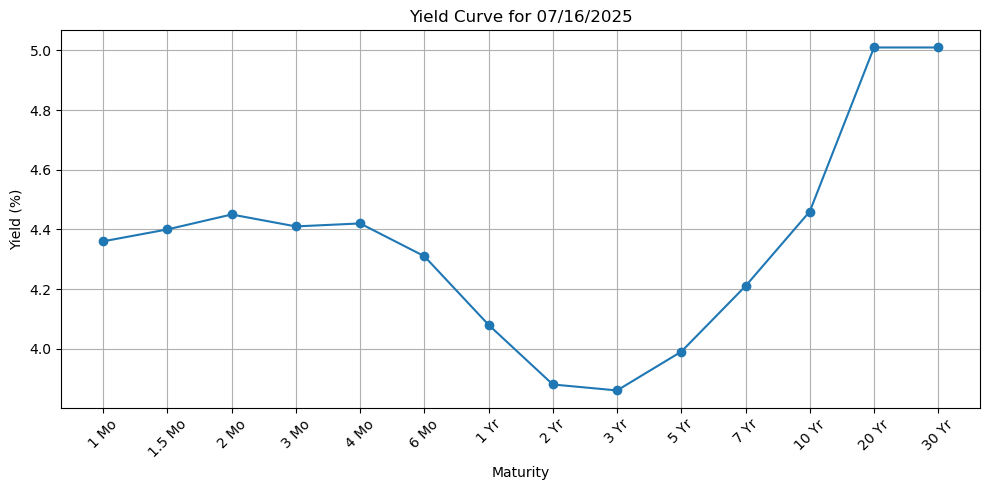

In [5]:
# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(date_7_16_2025.columns[1:], date_7_16_2025.iloc[0, 1:], marker='o')
plt.title('Yield Curve for 07/16/2025')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

### Data preparation

In [6]:
# def maturity in years
def convert_maturity_to_years(maturity):
    if 'Yr' in maturity:
        return float(maturity.replace('Yr', '').strip())
    elif 'Mo' in maturity:
        return float(maturity.replace('Mo', '').strip()) / 12

In [7]:
# transpose the data for better readability and remove date row and rename columns
data_7_16_2025 = date_7_16_2025.T
data_7_16_2025.columns = ['Yield %']
data_7_16_2025 = data_7_16_2025.iloc[1:]
data_7_16_2025.reset_index(inplace=True)
data_7_16_2025.rename(columns={'index': 'Maturity'}, inplace=True)

# Adding the 'Maturity' column as a numeric type as a new column. If Yr , then extract the number. If Mo, then convert to years dividing by 12.
data_7_16_2025['Maturity (Years)'] = round(data_7_16_2025['Maturity'].apply(convert_maturity_to_years),3)
data_7_16_2025

,Maturity,Yield %,Maturity (Years)
0,1 Mo,4.36,0.083
1,1.5 Mo,4.4,0.125
2,2 Mo,4.45,0.167
3,3 Mo,4.41,0.250
4,4 Mo,4.42,0.333
5,6 Mo,4.31,0.500
6,1 Yr,4.08,1.000
7,2 Yr,3.88,2.000
8,3 Yr,3.86,3.000
9,5 Yr,3.99,5.000


## Nelson Siegel Model

### Calibration using non linear curve fitting

In [8]:
# NS model calibration
def nelson_siegel_model(t, beta0, beta1, beta2, lambd):
    t = np.array(t)
    # Avoid division by zero for very small t
    t = np.where(t == 0, 1e-6, t)
    term1 = (1 - np.exp(-lambd * t)) / (lambd * t)
    term2 = term1 - np.exp(-lambd * t)
    return beta0 + beta1 * term1 + beta2 * term2

def objective(params, t, yields):
    beta0, beta1, beta2, lambd = params
    fitted = nelson_siegel_model(t, beta0, beta1, beta2, lambd)
    return np.sum((yields - fitted) ** 2)

In [9]:
maturities = data_7_16_2025["Maturity (Years)"].values
yields = data_7_16_2025["Yield %"].values

# Initial guess and bounds (length 4!)
initial_guess = [4, -1, 1, 0.5]
bounds = [(0, 8),   # beta0
          (-10, 10),   # beta1
          (-10, 10),   # beta2
          (0.001, 10)]  # lambd

# Fit using minimize
result = minimize(
    objective,
    initial_guess,
    args=(maturities, yields),
    bounds=bounds,
    method='L-BFGS-B',
    options={'maxiter': 10000}
)

# Extract results
beta0, beta1, beta2, lambd = result.x
print(f"Fitted parameters:")
print(f"beta0 = {beta0:.4f}")
print(f"beta1 = {beta1:.4f}")
print(f"beta2 = {beta2:.4f}")
print(f"lambda = {lambd:.4f}")

Fitted parameters:
beta0 = 5.4196
beta1 = -0.9010
beta2 = -3.6287
lambda = 0.4512


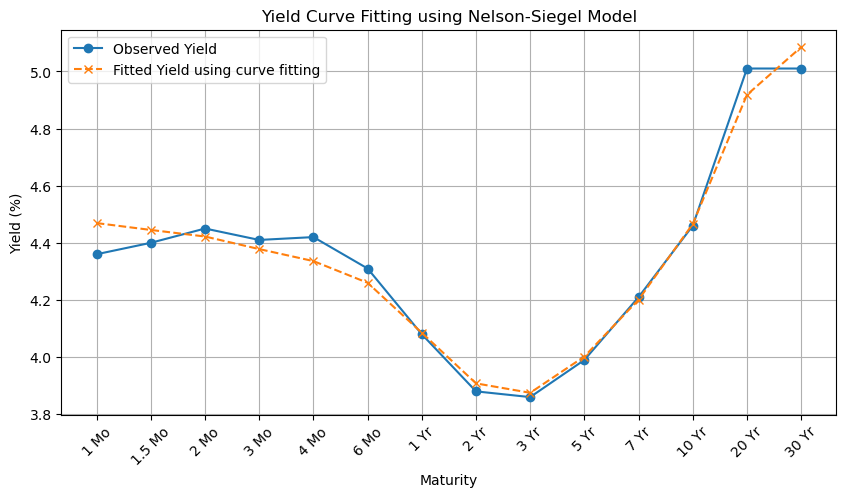

In [10]:
# Add fitted values to the DataFrame
data_7_16_2025['Fitted Yield % OLS(NS)'] = nelson_siegel_model(maturities, beta0, beta1, beta2, lambd)
# round the fitted values to 3 decimal places
data_7_16_2025['Fitted Yield % OLS(NS)'] = data_7_16_2025['Fitted Yield % OLS(NS)'].round(3)
# Plotting the original yields and fitted curve vs the maturities
plt.figure(figsize=(10, 5))
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Yield %'], marker='o', label='Observed Yield')
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % OLS(NS)'], marker='x', linestyle='--', label='Fitted Yield using curve fitting')
plt.title('Yield Curve Fitting using Nelson-Siegel Model')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


### Calibration using MLE

In [11]:
def neg_log_likelihood(params_mle, t, y):
    beta0_mle, beta1_mle, beta2_mle, lambd_mle, sigma_mle = params_mle
    y_hat = nelson_siegel_model(t, beta0_mle, beta1_mle, beta2_mle, lambd_mle)
    n = len(y)
    # NLL for Gaussian
    nll = 0.5 * n * np.log(2 * np.pi * sigma_mle ** 2) + 0.5 * np.sum((y - y_hat) ** 2) / sigma_mle ** 2
    return nll


In [12]:
initial_guess = [5.0, 1.0, 1.0, 0.1, 0.1]
bounds = [(-10, 20), (-20, 20), (-20, 20), (1e-6, 10), (1e-6, 2)]  # reasonable bounds

result = minimize(
    neg_log_likelihood,
    initial_guess,
    args=(maturities, yields),
    bounds=bounds,
    method='L-BFGS-B'
)

beta0_mle, beta1_mle, beta2_mle, lambd_mle, sigma_mle = result.x

print("Fitted parameters (MLE):")
print(f"beta0_mle = {beta0_mle:.4f}")
print(f"beta1_mle = {beta1_mle:.4f}")
print(f"beta2_mle = {beta2_mle:.4f}")
print(f"lambda_mle = {lambd_mle:.4f}")
print(f"sigma_mle = {sigma_mle:.4f}")

Fitted parameters (MLE):
beta0_mle = 5.4196
beta1_mle = -0.9010
beta2_mle = -3.6287
lambda_mle = 0.4512
sigma_mle = 0.0538


In [13]:
# adding fitted values to the DataFrame
data_7_16_2025['Fitted Yield % MLE (NS)'] = nelson_siegel_model(maturities, beta0_mle, beta1_mle, beta2_mle, lambd_mle)
# round the fitted values to 3 decimal places
data_7_16_2025['Fitted Yield % MLE (NS)'] = data_7_16_2025['Fitted Yield % MLE (NS)'].round(3)


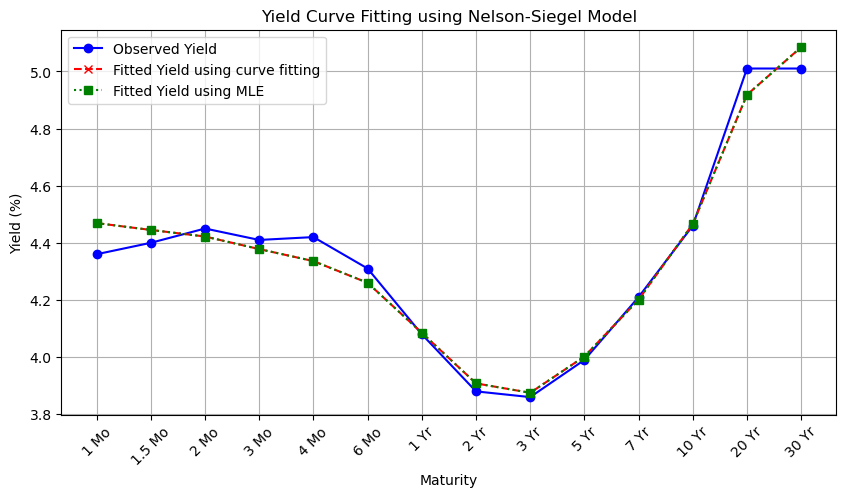

In [14]:
#plotting  original yields, fitted , MLE fitted vs maturities
plt.figure(figsize=(10, 5))
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Yield %'], marker='o',color = 'b', label='Observed Yield')
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % OLS(NS)'], marker='x',color = 'r', linestyle='--', label='Fitted Yield using curve fitting')
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % MLE (NS)'], marker='s',color = 'g', linestyle=':', label='Fitted Yield using MLE')
plt.title('Yield Curve Fitting using Nelson-Siegel Model')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

### Why did we get the same optimized parameters for mle and non linear curve fitting?
Nonlinear curve fitting (least squares) and Maximum Likelihood Estimation (MLE) both solve for the parameters that best fit your data.

If you assume Gaussian (normal) errors, then minimizing sum of squared errors (SSE) (what curve fitting does) is mathematically equivalent to maximizing the likelihood (MLE).

So both methods, when applied correctly to the same model and data, will yield the same optimal parameters.

### Testing the data

In [15]:
# find the yeild for 1 Mo, 1.5 Mo, 2 Mo, 2.5 Mo, 3 Mo, 3.5 Mo, 4 Mo, 4.5 Mo, 5 Mo, 5.5 Mo, 6 Mo, 6.5 Mo, 7 Mo, 7.5 Mo, 8 Mo, 8.5 Mo, 9 Mo, 9.5 Mo, 10 Mo, 10.5 Mo, 11 Mo, 11.5 Mo, 12 Mo, 1 Yr, 2 Yr, 3 Yr, 4 Yr, 5 Yr, 6 Yr, 7 Yr, 8 Yr, 9 Yr, 10 Yr, 11 Yr, 12 Yr, 13 Yr, 14 Yr, 15 Yr, 16 Yr, 17 Yr, 18 Yr, 19 Yr, 20 Yr, 21 Yr, 22 Yr, 23 Yr, 24 Yr, 25 Yr, 26 Yr, 27 Yr, 28 Yr, 29 Yr, 30 Yr
maturities_to_check = [1/12, 2/12, 3/12, 4/12,  5/12, 6/12,  7/12, 8/12, 9/12, 10/12, 11/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
yields_to_check = nelson_siegel_model(maturities_to_check, beta0, beta1, beta2, lambd)
print("Yields for specific maturities:")
for maturity, yield_value in zip(maturities_to_check, yields_to_check):
    print(f"Maturity: {maturity:.2f} years, Yield: {yield_value:.4f} %")

# store it in a DataFrame
test_yields_df = pd.DataFrame({
    'Maturity (Years)': maturities_to_check,
    'Yield % OLS (NS)': nelson_siegel_model(maturities_to_check, beta0, beta1, beta2, lambd),})


Yields for specific maturities:
Maturity: 0.08 years, Yield: 4.4688 %
Maturity: 0.17 years, Yield: 4.4219 %
Maturity: 0.25 years, Yield: 4.3777 %
Maturity: 0.33 years, Yield: 4.3361 %
Maturity: 0.42 years, Yield: 4.2970 %
Maturity: 0.50 years, Yield: 4.2604 %
Maturity: 0.58 years, Yield: 4.2260 %
Maturity: 0.67 years, Yield: 4.1938 %
Maturity: 0.75 years, Yield: 4.1637 %
Maturity: 0.83 years, Yield: 4.1356 %
Maturity: 0.92 years, Yield: 4.1094 %
Maturity: 1.00 years, Yield: 4.0850 %
Maturity: 2.00 years, Yield: 3.9077 %
Maturity: 3.00 years, Yield: 3.8749 %
Maturity: 4.00 years, Yield: 3.9196 %
Maturity: 5.00 years, Yield: 4.0023 %
Maturity: 6.00 years, Yield: 4.1001 %
Maturity: 7.00 years, Yield: 4.2005 %
Maturity: 8.00 years, Yield: 4.2968 %
Maturity: 9.00 years, Yield: 4.3858 %
Maturity: 10.00 years, Yield: 4.4665 %
Maturity: 11.00 years, Yield: 4.5386 %
Maturity: 12.00 years, Yield: 4.6028 %
Maturity: 13.00 years, Yield: 4.6598 %
Maturity: 14.00 years, Yield: 4.7103 %
Maturity: 15.

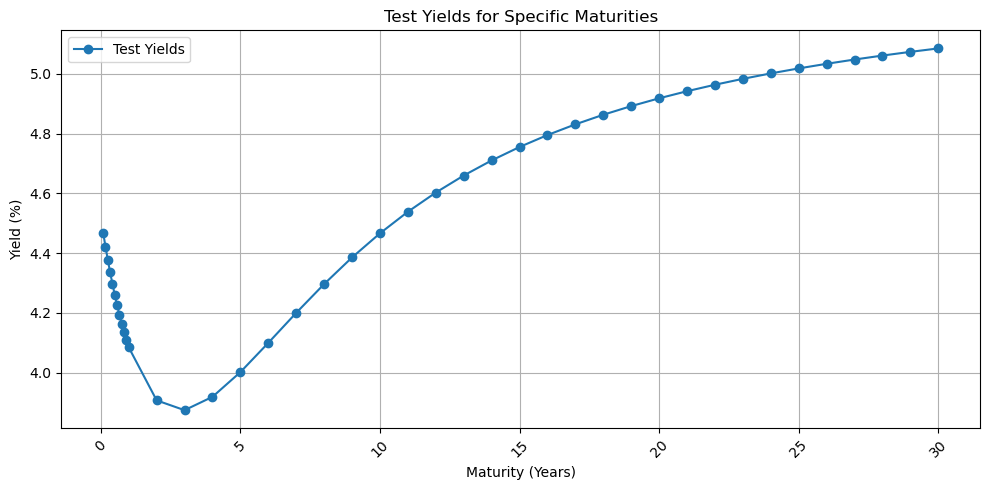

In [16]:
# plot the test yields with yields number on each point with equal spacing and the values not clashing on each other
plt.figure(figsize=(10, 5))
plt.plot(maturities_to_check, yields_to_check, marker='o', label='Test Yields')

plt.title('Test Yields for Specific Maturities')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [17]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=maturities_to_check,
    y=yields_to_check,
    mode='markers+lines',
    name='Test Yields',
    marker=dict(size=8)
))

fig.update_layout(
    title='Test Yields for Specific Maturities',
    xaxis_title='Maturity (Years)',
    yaxis_title='Yield (%)',
    xaxis=dict(tickangle=45),
    legend=dict(x=0.01, y=0.99),
    template='plotly_dark',  # <-- set background to black
    width=900,
    height=400
)

## Nelson Siegel Svensson Model

In [18]:
def nelson_siegel_svensson_model(t, beta0, beta1, beta2, beta3, lambd1, lambd2):
    t = np.array(t)
    # Avoid division by zero for very small t
    t = np.where(t == 0, 1e-6, t)
    term1 = (1 - np.exp(-lambd1 * t)) / (lambd1 * t)
    term2 = term1 - np.exp(-lambd1 * t)
    term3 = ((1 - np.exp(-lambd2 * t)) / (lambd2 * t)) - np.exp(-lambd2 * t)
    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3


In [19]:
def objective(params, t, yields):
    beta0, beta1, beta2, beta3, lambd1, lambd2 = params
    fitted = nelson_siegel_svensson_model(t, beta0, beta1, beta2, beta3, lambd1, lambd2)
    return np.sum((yields - fitted) ** 2)

In [20]:
maturities = data_7_16_2025["Maturity (Years)"].values
yields = data_7_16_2025["Yield %"].values

# Initial guess: beta0, beta1, beta2, beta3, lambd1, lambd2
initial_guess = [5, 1.0, 1.0, 1.0, 0.5, 0.5]

# For NSS (6 parameters: beta0, beta1, beta2, beta3, lambd1, lambd2)
bounds = [(3, 6),  # beta0
          (-10, 10),  # beta1
          (-10, 10),  # beta2
          (-10, 10),  # beta3
          (0.001, 10), # lambd1
          (0.001, 10)] # lambd2


# Fit using minimize
result = minimize(
    objective,
    initial_guess,
    args=(maturities, yields),
    bounds=bounds,
    method='L-BFGS-B',
    options={'maxiter': 10000}
)


beta0, beta1, beta2, beta3, lambd1, lambd2 = result.x

print(f"Fitted parameters:")
print(f"beta0  = {beta0:.4f}")
print(f"beta1  = {beta1:.4f}")
print(f"beta2  = {beta2:.4f}")
print(f"beta3  = {beta3:.4f}")
print(f"lambda1 = {lambd1:.4f}")
print(f"lambda2 = {lambd2:.4f}")

Fitted parameters:
beta0  = 5.3432
beta1  = -0.9729
beta2  = 0.0000
beta3  = -4.8305
lambda1 = 3.8886
lambda2 = 0.5834


In [21]:
# Add fitted values to the DataFrame
data_7_16_2025['Fitted Yield % OLS(NSS)'] = nelson_siegel_svensson_model(maturities, beta0, beta1, beta2, beta3, lambd1, lambd2)
# round the fitted values to 3 decimal places
data_7_16_2025['Fitted Yield % OLS(NSS)'] = data_7_16_2025['Fitted Yield % OLS(NSS)'].round(3)

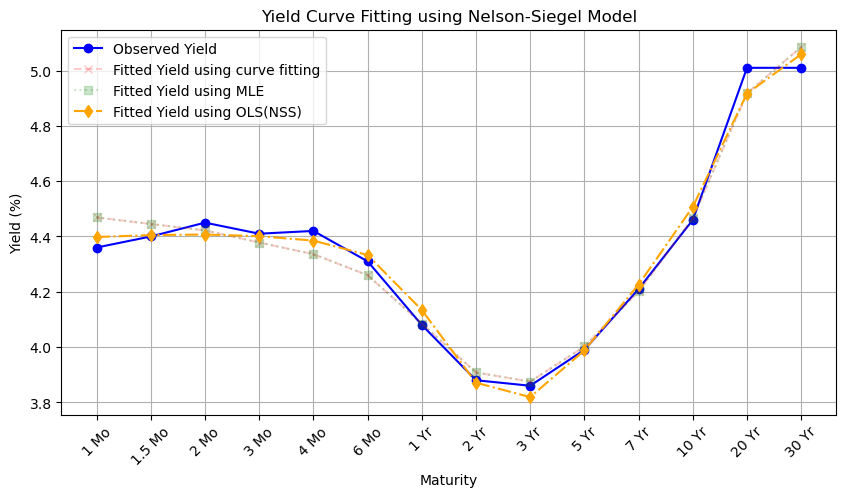

In [22]:
#plotting  original yields, fitted , MLE fitted vs maturities
plt.figure(figsize=(10, 5))
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Yield %'], marker='o',color = 'b', label='Observed Yield')
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % OLS(NS)'], marker='x',color = 'r', linestyle='--', label='Fitted Yield using curve fitting',alpha=0.2)
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % MLE (NS)'], marker='s',color = 'g', linestyle=':', label='Fitted Yield using MLE', alpha=0.2)
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % OLS(NSS)'], marker='d', color='orange', linestyle='-.', label='Fitted Yield using OLS(NSS)')
plt.title('Yield Curve Fitting using Nelson-Siegel Model')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

### Testing the data

In [23]:
# find the yeild for 1 Mo, 1.5 Mo, 2 Mo, 2.5 Mo, 3 Mo, 3.5 Mo, 4 Mo, 4.5 Mo, 5 Mo, 5.5 Mo, 6 Mo, 6.5 Mo, 7 Mo, 7.5 Mo, 8 Mo, 8.5 Mo, 9 Mo, 9.5 Mo, 10 Mo, 10.5 Mo, 11 Mo, 11.5 Mo, 12 Mo, 1 Yr, 2 Yr, 3 Yr, 4 Yr, 5 Yr, 6 Yr, 7 Yr, 8 Yr, 9 Yr, 10 Yr, 11 Yr, 12 Yr, 13 Yr, 14 Yr, 15 Yr, 16 Yr, 17 Yr, 18 Yr, 19 Yr, 20 Yr, 21 Yr, 22 Yr, 23 Yr, 24 Yr, 25 Yr, 26 Yr, 27 Yr, 28 Yr, 29 Yr, 30 Yr
maturities_to_check = [1/12, 2/12, 3/12, 4/12,  5/12, 6/12,  7/12, 8/12, 9/12, 10/12, 11/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
yields_to_check = nelson_siegel_svensson_model(maturities_to_check, beta0, beta1, beta2, beta3, lambd1, lambd2)
print("Yields for specific maturities:")
for maturity, yield_value in zip(maturities_to_check, yields_to_check):
    print(f"Maturity: {maturity:.2f} years, Yield: {yield_value:.4f} %")

Yields for specific maturities:
Maturity: 0.08 years, Yield: 4.3986 %
Maturity: 0.17 years, Yield: 4.4071 %
Maturity: 0.25 years, Yield: 4.4012 %
Maturity: 0.33 years, Yield: 4.3850 %
Maturity: 0.42 years, Yield: 4.3615 %
Maturity: 0.50 years, Yield: 4.3330 %
Maturity: 0.58 years, Yield: 4.3015 %
Maturity: 0.67 years, Yield: 4.2681 %
Maturity: 0.75 years, Yield: 4.2340 %
Maturity: 0.83 years, Yield: 4.1999 %
Maturity: 0.92 years, Yield: 4.1664 %
Maturity: 1.00 years, Yield: 4.1338 %
Maturity: 2.00 years, Yield: 3.8713 %
Maturity: 3.00 years, Yield: 3.8186 %
Maturity: 4.00 years, Yield: 3.8797 %
Maturity: 5.00 years, Yield: 3.9881 %
Maturity: 6.00 years, Yield: 4.1090 %
Maturity: 7.00 years, Yield: 4.2259 %
Maturity: 8.00 years, Yield: 4.3321 %
Maturity: 9.00 years, Yield: 4.4256 %
Maturity: 10.00 years, Yield: 4.5068 %
Maturity: 11.00 years, Yield: 4.5769 %
Maturity: 12.00 years, Yield: 4.6374 %
Maturity: 13.00 years, Yield: 4.6898 %
Maturity: 14.00 years, Yield: 4.7355 %
Maturity: 15.

In [24]:
# append this to the test_yields_df DataFrame
test_yields_df['Yield % OLS (NSS)'] = yields_to_check

In [25]:
test_yields_df

,Maturity (Years),Yield % OLS (NS),Yield % OLS (NSS)
0,0.083333,4.468814,4.398567
1,0.166667,4.421879,4.407094
2,0.250000,4.377684,4.401222
3,0.333333,4.336110,4.384990
4,0.416667,4.297043,4.361481
5,0.500000,4.260371,4.333046
6,0.583333,4.225989,4.301472
7,0.666667,4.193795,4.268114
8,0.750000,4.163693,4.233998
9,0.833333,4.135588,4.199890


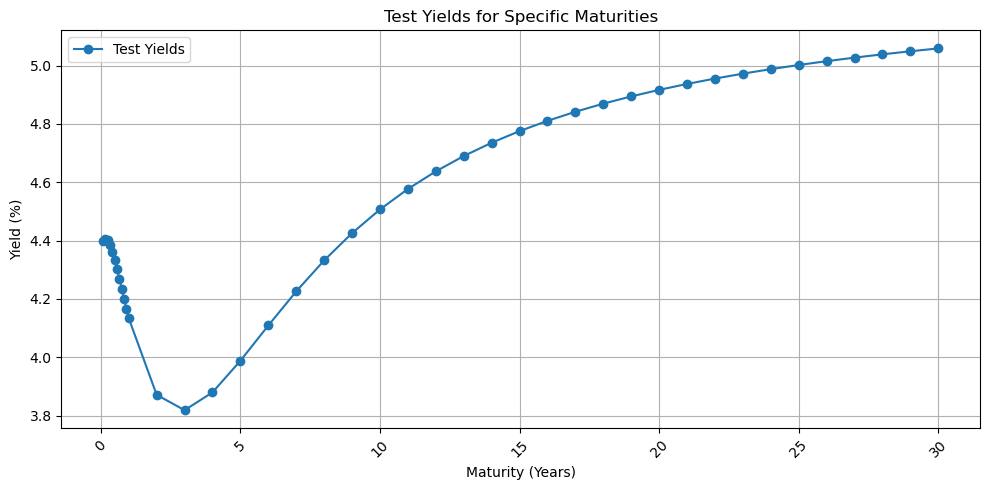

In [26]:
# plot the test yields with yields number on each point with equal spacing and the values not clashing on each other
plt.figure(figsize=(10, 5))
plt.plot(maturities_to_check, yields_to_check, marker='o', label='Test Yields')

plt.title('Test Yields for Specific Maturities')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [27]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=maturities_to_check,
    y=yields_to_check,
    mode='markers+lines',
    name='Test Yields',
    marker=dict(size=8)
))

fig.update_layout(
    title='Test Yields for Specific Maturities',
    xaxis_title='Maturity (Years)',
    yaxis_title='Yield (%)',
    xaxis=dict(tickangle=45),
    legend=dict(x=0.01, y=0.99),
    template='plotly_dark',  # <-- set background to black
    width=900,
    height=400
)

## Linear Interpolation

In [28]:
data_7_16_2025

,Maturity,Yield %,Maturity (Years),Fitted Yield % OLS(NS),Fitted Yield % MLE (NS),Fitted Yield % OLS(NSS)
0,1 Mo,4.36,0.083,4.469,4.469,4.398
1,1.5 Mo,4.4,0.125,4.445,4.445,4.405
2,2 Mo,4.45,0.167,4.422,4.422,4.407
3,3 Mo,4.41,0.250,4.378,4.378,4.401
4,4 Mo,4.42,0.333,4.336,4.336,4.385
5,6 Mo,4.31,0.500,4.260,4.260,4.333
6,1 Yr,4.08,1.000,4.085,4.085,4.134
7,2 Yr,3.88,2.000,3.908,3.908,3.871
8,3 Yr,3.86,3.000,3.875,3.875,3.819
9,5 Yr,3.99,5.000,4.002,4.002,3.988


In [29]:
maturities = np.array([data_7_16_2025["Maturity (Years)"].values]).flatten()
yields = np.array([data_7_16_2025["Yield %"].values]).flatten()

In [30]:
# Extract data from your DataFrame and convert to clean arrays
maturities = np.asarray(data_7_16_2025["Maturity (Years)"].values, dtype=float).flatten()
yields = np.asarray(data_7_16_2025["Yield %"].values, dtype=float).flatten()

maturities_to_interpolate = [1/12, 2/12, 3/12, 4/12,  5/12, 6/12,  7/12, 8/12, 9/12, 10/12, 11/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                       11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

# Interpolate yields for the desired maturities
interpolated_yields = np.interp(maturities_to_interpolate, maturities, yields)

# Display results
print("Interpolation Results:")
for i, (m, y) in enumerate(zip(maturities_to_interpolate, interpolated_yields)):
    print(f"Maturity: {m:.4f} years -> Interpolated Yield: {y:.4f}%")

Interpolation Results:
Maturity: 0.0833 years -> Interpolated Yield: 4.3603%
Maturity: 0.1667 years -> Interpolated Yield: 4.4496%
Maturity: 0.2500 years -> Interpolated Yield: 4.4100%
Maturity: 0.3333 years -> Interpolated Yield: 4.4198%
Maturity: 0.4167 years -> Interpolated Yield: 4.3649%
Maturity: 0.5000 years -> Interpolated Yield: 4.3100%
Maturity: 0.5833 years -> Interpolated Yield: 4.2717%
Maturity: 0.6667 years -> Interpolated Yield: 4.2333%
Maturity: 0.7500 years -> Interpolated Yield: 4.1950%
Maturity: 0.8333 years -> Interpolated Yield: 4.1567%
Maturity: 0.9167 years -> Interpolated Yield: 4.1183%
Maturity: 1.0000 years -> Interpolated Yield: 4.0800%
Maturity: 2.0000 years -> Interpolated Yield: 3.8800%
Maturity: 3.0000 years -> Interpolated Yield: 3.8600%
Maturity: 4.0000 years -> Interpolated Yield: 3.9250%
Maturity: 5.0000 years -> Interpolated Yield: 3.9900%
Maturity: 6.0000 years -> Interpolated Yield: 4.1000%
Maturity: 7.0000 years -> Interpolated Yield: 4.2100%
Matur

In [31]:
def linear_interpolate(x0, y0, x1, y1, x):
    return y0 + (x - x0) * (y1 - y0) / (x1 - x0)

maturities = [0.083, 0.125, 0.167, 0.25, 0.333, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
yields = [4.36, 4.4, 4.45, 4.41, 4.42, 4.31, 4.08, 3.88, 3.86, 3.99, 4.21, 4.46, 5.01, 5.01]

targets = [5/12, 7/12, 8/12, 9/12, 10/12, 11/12, 4, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29]

def interpolate_yield(maturities, yields, x):
    # Handle if x is out of range
    if x < maturities[0] or x > maturities[-1]:
        return None  # or np.nan
    for i in range(1, len(maturities)):
        if maturities[i-1] <= x <= maturities[i]:
            return linear_interpolate(maturities[i-1], yields[i-1], maturities[i], yields[i], x)
    return None

results = []
for t in targets:
    y = interpolate_yield(maturities, yields, t)
    results.append((t, y))

# Print nicely
for t, y in results:
    if y is not None:
        print(f"Maturity: {t:.4f} years -> Interpolated Yield: {y:.4f}%")
    else:
        print(f"Maturity: {t:.4f} years -> Out of range")


Maturity: 0.4167 years -> Interpolated Yield: 4.3649%
Maturity: 0.5833 years -> Interpolated Yield: 4.2717%
Maturity: 0.6667 years -> Interpolated Yield: 4.2333%
Maturity: 0.7500 years -> Interpolated Yield: 4.1950%
Maturity: 0.8333 years -> Interpolated Yield: 4.1567%
Maturity: 0.9167 years -> Interpolated Yield: 4.1183%
Maturity: 4.0000 years -> Interpolated Yield: 3.9250%
Maturity: 6.0000 years -> Interpolated Yield: 4.1000%
Maturity: 8.0000 years -> Interpolated Yield: 4.2933%
Maturity: 9.0000 years -> Interpolated Yield: 4.3767%
Maturity: 11.0000 years -> Interpolated Yield: 4.5150%
Maturity: 12.0000 years -> Interpolated Yield: 4.5700%
Maturity: 13.0000 years -> Interpolated Yield: 4.6250%
Maturity: 14.0000 years -> Interpolated Yield: 4.6800%
Maturity: 15.0000 years -> Interpolated Yield: 4.7350%
Maturity: 16.0000 years -> Interpolated Yield: 4.7900%
Maturity: 17.0000 years -> Interpolated Yield: 4.8450%
Maturity: 18.0000 years -> Interpolated Yield: 4.9000%
Maturity: 19.0000 ye

In [32]:
# merge the results with the maturities and yields lists
results_df = pd.DataFrame(results, columns=['Maturity (Years)', 'Interpolated Yield (%)'])
results_df['Maturity (Years)'] = results_df['Maturity (Years)']
results_df['Interpolated Yield (%)'] = results_df['Interpolated Yield (%)']

maturities = [0.083, 0.125, 0.167, 0.25, 0.333, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
yields = [4.36, 4.4, 4.45, 4.41, 4.42, 4.31, 4.08, 3.88, 3.86, 3.99, 4.21, 4.46, 5.01, 5.01]

# Create a DataFrame for the original maturities and yields
original_df = pd.DataFrame({
    'Maturity (Years)': maturities,
    'Yield (%)': yields
})

# Merge the original DataFrame with the results DataFrame
merged_df = pd.merge(original_df, results_df, on='Maturity (Years)', how='outer', suffixes=('_Original', '_Interpolated'))


# create an other column with both original and interpolated yields
merged_df['Final Yield (%)'] = merged_df['Yield (%)'].combine_first(merged_df['Interpolated Yield (%)'])


In [33]:
# append this to the test_yields_df DataFrame
test_yields_df['Yield % (LI)'] = merged_df['Final Yield (%)']

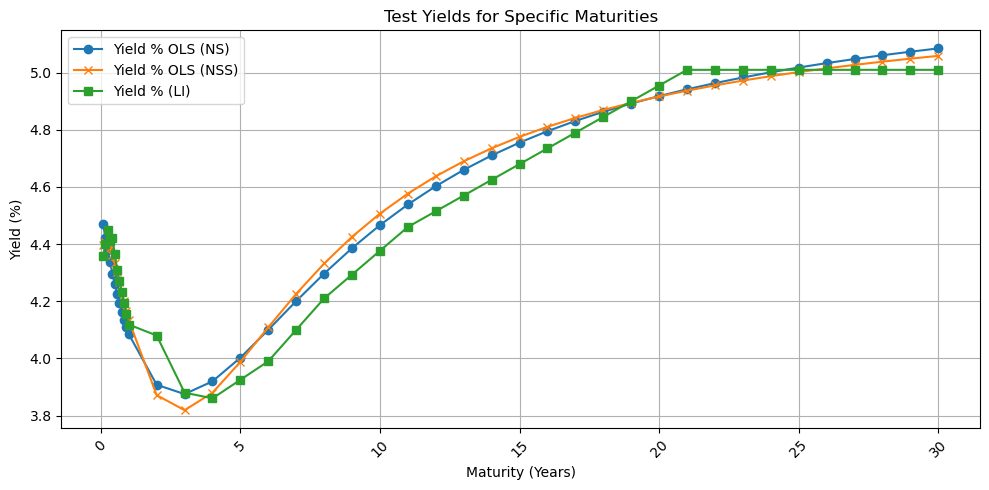

In [34]:
# plot the test_yields_df
plt.figure(figsize=(10, 5))
plt.plot(test_yields_df['Maturity (Years)'], test_yields_df['Yield % OLS (NS)'], marker='o', label='Yield % OLS (NS)')
plt.plot(test_yields_df['Maturity (Years)'], test_yields_df['Yield % OLS (NSS)'], marker='x', label='Yield % OLS (NSS)')
plt.plot(test_yields_df['Maturity (Years)'], test_yields_df['Yield % (LI)'], marker='s', label='Yield % (LI)')
plt.title('Test Yields for Specific Maturities')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Cubic Spline Interpolation

In [35]:
from scipy.interpolate import CubicSpline

# Prepare the original maturities and yields as arrays
maturities_array = np.array(original_df['Maturity (Years)'])
yields_array = np.array(original_df['Yield (%)'])

# Create cubic spline interpolator
cs = CubicSpline(maturities_array, yields_array)

# Interpolate for the desired maturities
cubic_spline_yields = cs(maturities_to_check)

# Add results to test_yields_df
test_yields_df['Yield % (CS)'] = cubic_spline_yields



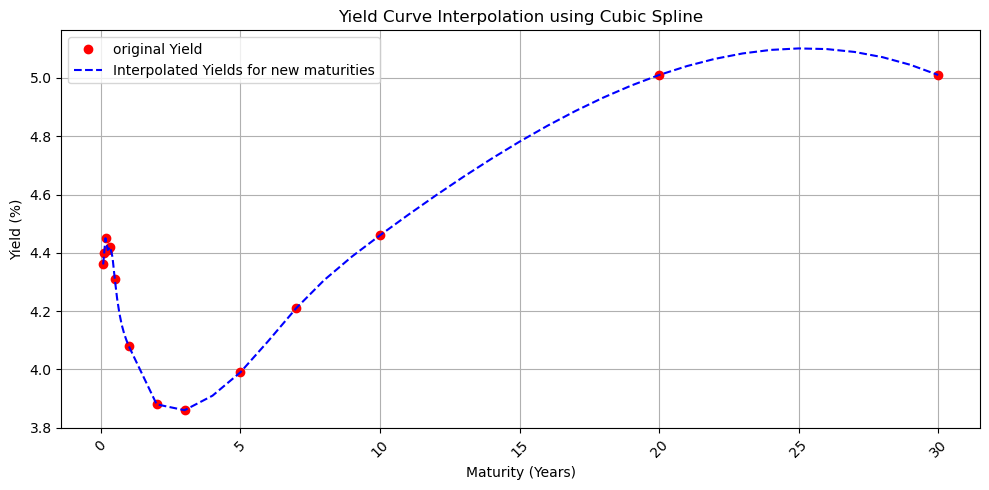

In [36]:
# plotting 
plt.figure(figsize=(10, 5))
plt.plot(maturities, yields,'o',color= 'red', label='original Yield')
plt.plot(maturities_to_check, test_yields_df['Yield % (CS)'], '--', color='blue', label = 'Interpolated Yields for new maturities')
plt.title('Yield Curve Interpolation using Cubic Spline')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Conclusion

## plots

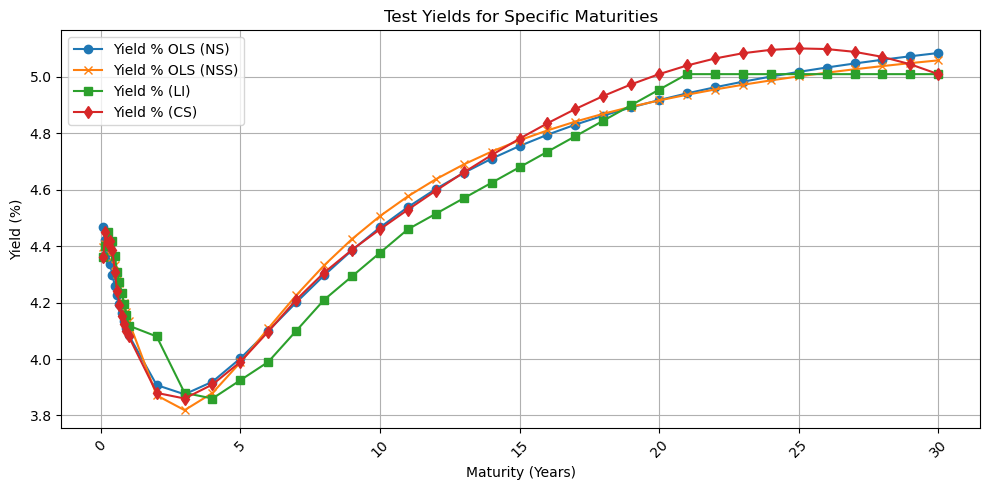

In [37]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(test_yields_df['Maturity (Years)'], test_yields_df['Yield % OLS (NS)'], marker='o', label='Yield % OLS (NS)')
plt.plot(test_yields_df['Maturity (Years)'], test_yields_df['Yield % OLS (NSS)'], marker='x', label='Yield % OLS (NSS)')
plt.plot(test_yields_df['Maturity (Years)'], test_yields_df['Yield % (LI)'], marker='s', label='Yield % (LI)')
plt.plot(test_yields_df['Maturity (Years)'], test_yields_df['Yield % (CS)'], marker='d', label='Yield % (CS)')
plt.title('Test Yields for Specific Maturities')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [38]:
initial_yield_curve = data_7_16_2025

In [39]:
test_yields_df

,Maturity (Years),Yield % OLS (NS),Yield % OLS (NSS),Yield % (LI),Yield % (CS)
0,0.083333,4.468814,4.398567,4.360000,4.360021
1,0.166667,4.421879,4.407094,4.400000,4.449821
2,0.250000,4.377684,4.401222,4.450000,4.410000
3,0.333333,4.336110,4.384990,4.410000,4.420028
4,0.416667,4.297043,4.361481,4.420000,4.385813
5,0.500000,4.260371,4.333046,4.364890,4.310000
6,0.583333,4.225989,4.301472,4.310000,4.242651
7,0.666667,4.193795,4.268114,4.271667,4.191201
8,0.750000,4.163693,4.233998,4.233333,4.152431
9,0.833333,4.135588,4.199890,4.195000,4.123121


## Error metrics

In [40]:
# Actual yields
y_actual = data_7_16_2025['Yield %']

# Fitted yields for each model
y_ns = data_7_16_2025['Fitted Yield % OLS(NS)']
y_nss = data_7_16_2025['Fitted Yield % OLS(NSS)']

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# NS Model
rmse_ns = rmse(y_actual, y_ns)
mae_ns = mae(y_actual, y_ns)

# NSS Model
rmse_nss = rmse(y_actual, y_nss)
mae_nss = mae(y_actual, y_nss)

print(f"NS Model: RMSE = {rmse_ns:.4f}, MAE = {mae_ns:.4f}")
print(f"NSS Model: RMSE = {rmse_nss:.4f}, MAE = {mae_nss:.4f}")


NS Model: RMSE = 0.0539, MAE = 0.0421
NSS Model: RMSE = 0.0408, MAE = 0.0331


## Parameter stability

In [41]:
df = pd.read_csv('daily-treasury-rates.csv')

# remove 1.5 Mo column
df = df.drop(columns=['1.5 Mo'])

In [42]:
df.isna().sum()

Date     0
1 Mo     0
2 Mo     0
3 Mo     0
4 Mo     0
6 Mo     0
1 Yr     0
2 Yr     0
3 Yr     0
5 Yr     0
7 Yr     0
10 Yr    0
20 Yr    0
30 Yr    0
dtype: int64

In [43]:
df

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,7/16/2025,4.36,4.45,4.41,4.42,4.31,4.08,3.88,3.86,3.99,4.21,4.46,5.01,5.01
1,7/15/2025,4.36,4.46,4.42,4.43,4.33,4.12,3.95,3.93,4.05,4.26,4.50,5.02,5.01
2,7/14/2025,4.37,4.46,4.42,4.42,4.31,4.08,3.90,3.86,3.98,4.19,4.43,4.97,4.97
3,7/11/2025,4.37,4.47,4.41,4.42,4.31,4.09,3.90,3.86,3.99,4.19,4.43,4.96,4.96
4,7/10/2025,4.36,4.47,4.42,4.42,4.31,4.07,3.86,3.82,3.93,4.12,4.35,4.87,4.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,1/8/2025,4.41,4.34,4.35,4.31,4.25,4.19,4.28,4.31,4.45,4.56,4.67,4.97,4.91
130,1/7/2025,4.42,4.35,4.35,4.31,4.24,4.19,4.30,4.33,4.46,4.57,4.67,4.97,4.91
131,1/6/2025,4.43,4.36,4.35,4.31,4.24,4.17,4.28,4.30,4.42,4.52,4.62,4.91,4.85
132,1/3/2025,4.44,4.35,4.34,4.31,4.25,4.18,4.28,4.32,4.41,4.51,4.60,4.88,4.82


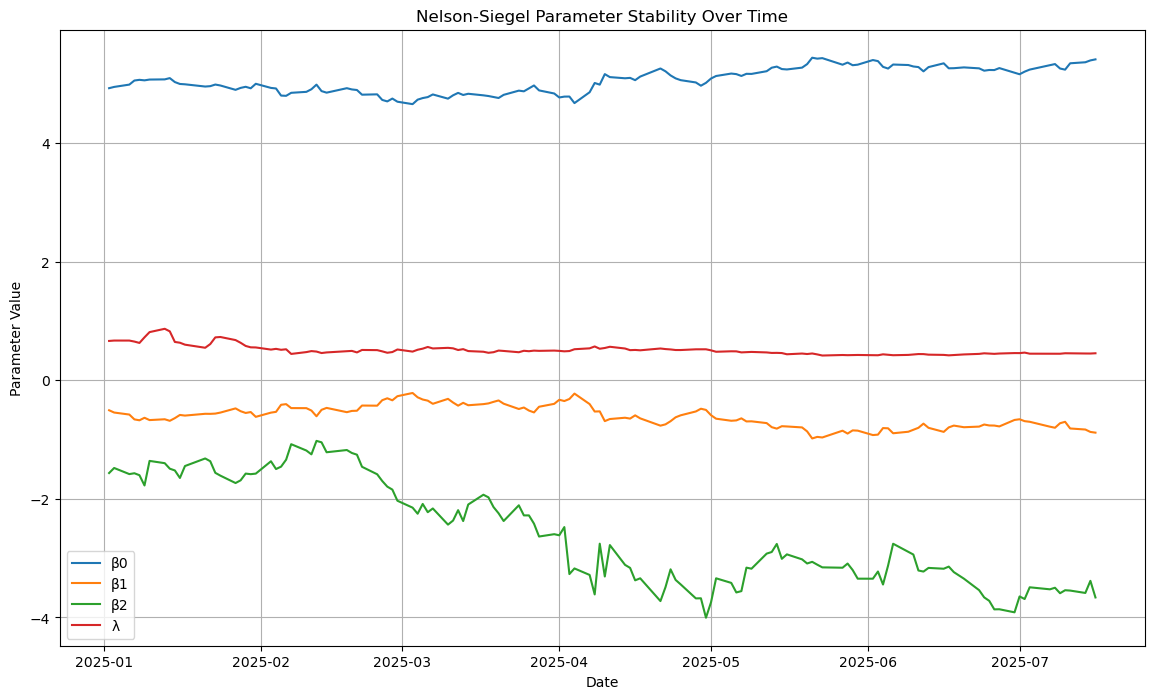

In [44]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# --- Convert maturity column names to years ---
def convert_maturity_to_years(maturity):
    if 'Yr' in maturity:
        return float(maturity.replace('Yr', '').strip())
    elif 'Mo' in maturity:
        return float(maturity.replace('Mo', '').strip()) / 12

# --- Nelson-Siegel model and objective function ---
def nelson_siegel_model(t, beta0, beta1, beta2, lambd):
    t = np.array(t)
    t = np.where(t == 0, 1e-6, t)
    term1 = (1 - np.exp(-lambd * t)) / (lambd * t)
    term2 = term1 - np.exp(-lambd * t)
    return beta0 + beta1 * term1 + beta2 * term2

def objective(params, t, yields):
    beta0, beta1, beta2, lambd = params
    fitted = nelson_siegel_model(t, beta0, beta1, beta2, lambd)
    return np.sum((yields - fitted) ** 2)

# --- Parameter stability analysis ---
param_records = []

for idx, row in df.iterrows():
    date = row['Date']
    # Drop NaN columns (some maturities missing)
    yields_row = row.drop('Date').dropna()
    maturities = yields_row.index
    yields = yields_row.values.astype(float)
    maturities_in_years = [convert_maturity_to_years(m) for m in maturities]

    initial_guess = [5, 1, 1, 0.5]
    bounds = [(3, 6), (-10, 10), (-10, 10), (0.001, 2)]
    try:
        result = minimize(
            objective,
            initial_guess,
            args=(maturities_in_years, yields),
            bounds=bounds,
            method='L-BFGS-B',
            options={'maxiter': 10000}
        )
        beta0, beta1, beta2, lambd = result.x
        param_records.append({'Date': pd.to_datetime(date), 'beta0': beta0, 'beta1': beta1, 'beta2': beta2, 'lambda': lambd})
    except Exception as e:
        print(f"Skipped {date} due to error: {e}")
        continue

# --- Compile parameter DataFrame ---
param_df = pd.DataFrame(param_records).sort_values('Date')

# --- Plot parameter stability ---
plt.figure(figsize=(14, 8))
plt.plot(param_df['Date'], param_df['beta0'], label='β0')
plt.plot(param_df['Date'], param_df['beta1'], label='β1')
plt.plot(param_df['Date'], param_df['beta2'], label='β2')
plt.plot(param_df['Date'], param_df['lambda'], label='λ')
plt.xlabel('Date')
plt.ylabel('Parameter Value')
plt.title('Nelson-Siegel Parameter Stability Over Time')
plt.legend()
plt.grid()
plt.show()


In [45]:
param_df

,Date,beta0,beta1,beta2,lambda
133,2025-01-02,4.929293,-0.504727,-1.564077,0.664807
132,2025-01-03,4.950658,-0.543144,-1.478810,0.671278
131,2025-01-06,4.989714,-0.577181,-1.581705,0.671135
130,2025-01-07,5.058522,-0.658789,-1.567570,0.654210
129,2025-01-08,5.070220,-0.674081,-1.600544,0.631153
...,...,...,...,...,...
4,2025-07-10,5.242107,-0.699531,-3.541245,0.456962
3,2025-07-11,5.349323,-0.812065,-3.546930,0.455612
2,2025-07-14,5.366661,-0.829793,-3.587236,0.452928
1,2025-07-15,5.397933,-0.870504,-3.382923,0.452380


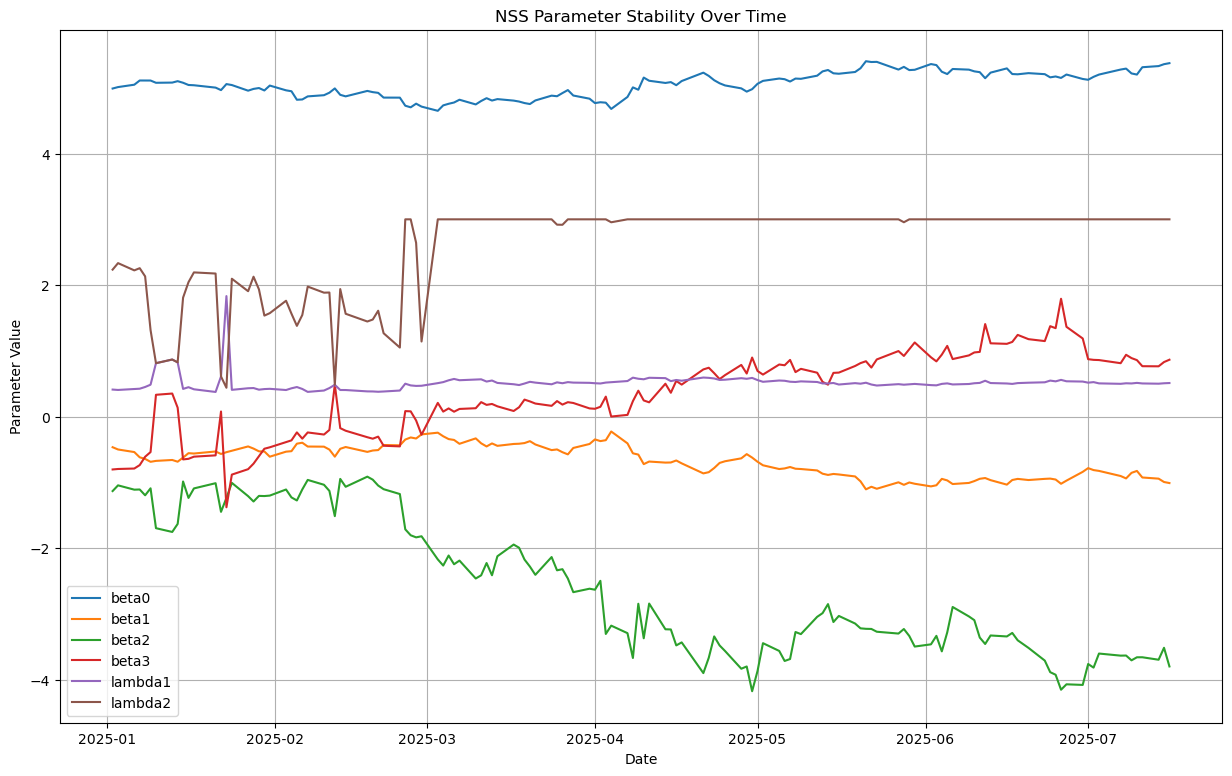

In [46]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Convert maturity column names to years
def convert_maturity_to_years(maturity):
    if 'Yr' in maturity:
        return float(maturity.replace('Yr', '').strip())
    elif 'Mo' in maturity:
        return float(maturity.replace('Mo', '').strip()) / 12

# NSS model
def nelson_siegel_svensson_model(t, beta0, beta1, beta2, beta3, lambda1, lambda2):
    t = np.array(t)
    t = np.where(t == 0, 1e-6, t)
    term1 = (1 - np.exp(-lambda1 * t)) / (lambda1 * t)
    term2 = term1 - np.exp(-lambda1 * t)
    term3 = (1 - np.exp(-lambda2 * t)) / (lambda2 * t) - np.exp(-lambda2 * t)
    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3

# Objective function for minimization
def objective_nss(params, t, yields):
    beta0, beta1, beta2, beta3, lambda1, lambda2 = params
    fitted = nelson_siegel_svensson_model(t, beta0, beta1, beta2, beta3, lambda1, lambda2)
    return np.sum((yields - fitted) ** 2)

# --- Parameter stability analysis for NSS ---
param_records = []

for idx, row in df.iterrows():
    date = row['Date']
    yields_row = row.drop('Date').dropna()
    maturities = yields_row.index
    yields = yields_row.values.astype(float)
    maturities_in_years = [convert_maturity_to_years(m) for m in maturities]
    if len(maturities_in_years) < 6:  # Need enough points for 6 parameters!
        continue

    # Initial guess and bounds for NSS
    initial_guess = [ 5.39945384 ,-1.18759124 ,-3.32734036 , 1.13344142 , 0.45834551 , 5.68577783]  # [β0, β1, β2, β3, λ1, λ2]
    bounds = [(3, 6),  # beta0
          (-10, 10),  # beta1
          (-10, 10),  # beta2
          (-10, 10),  # beta3
          (0.001, 3), # lambd1
          (0.001, 3)] # lambd2

    try:
        result = minimize(
            objective_nss,
            initial_guess,
            args=(maturities_in_years, yields),
            bounds=bounds,
            method='L-BFGS-B',
            options={'maxiter': 10000}
        )
        beta0, beta1, beta2, beta3, lambda1, lambda2 = result.x
        param_records.append({
            'Date': pd.to_datetime(date), 'beta0': beta0, 'beta1': beta1,
            'beta2': beta2, 'beta3': beta3, 'lambda1': lambda1, 'lambda2': lambda2
        })
    except Exception as e:
        print(f"Skipped {date} due to error: {e}")
        continue

# --- Create DataFrame of all parameters ---
param_df = pd.DataFrame(param_records).sort_values('Date')

# (Optional) Remove rows with extreme outliers
#param_df_clean = param_df[(param_df[['beta0','beta1','beta2','beta3','lambda1','lambda2']].abs() < 10).all(axis=1)]

# --- Plot parameter stability for NSS ---
plt.figure(figsize=(15, 9))
for col in ['beta0','beta1','beta2','beta3','lambda1','lambda2']:
    plt.plot(param_df['Date'], param_df[col], label=col)
plt.xlabel('Date')
plt.ylabel('Parameter Value')
plt.title('NSS Parameter Stability Over Time')
plt.legend()
plt.grid()
plt.show()


The erratic movement of the parameters might be due to the initial guess and bounds.

In [47]:
import itertools

# Use your first date as a test
first_row = df.iloc[0]
yields_row = first_row.drop('Date').dropna()
maturities = yields_row.index
yields = yields_row.values.astype(float)
maturities_in_years = [convert_maturity_to_years(m) for m in maturities]

# Define plausible grids for each parameter
beta0_grid = [np.median(yields), np.mean(yields)]
beta1_grid = [-1, 0, 1]
beta2_grid = [-1, 0, 1]
beta3_grid = [-1, 0, 1]
lambda1_grid = [0.3, 0.7, 1.0]
lambda2_grid = [0.3, 0.7, 1.0]

# Store results
best_result = None
best_params = None
lowest_error = np.inf

# Search all combinations
for guess in itertools.product(beta0_grid, beta1_grid, beta2_grid, beta3_grid, lambda1_grid, lambda2_grid):
    try:
        result = minimize(
            objective_nss,
            guess,
            args=(maturities_in_years, yields),
            bounds=[(3, 6),  # beta0
                    (-10, 10),  # beta1
                    (-10, 10),  # beta2
                    (-10, 10),  # beta3
                    (0.001, 10), # lambda1
                    (0.001, 10)],# lambda2
            method='L-BFGS-B',
            options={'maxiter': 10000}
        )
        error = result.fun
        if error < lowest_error:
            lowest_error = error
            best_params = result.x
            best_result = result
    except:
        continue

print("Best initial guess found on first date (for lowest error):", best_params)
print("Objective value:", lowest_error)


Best initial guess found on first date (for lowest error): [ 5.39945384 -1.18759124 -3.32734036  1.13344142  0.45834551  5.68577783]
Objective value: 0.015166474970378752


In [48]:
initial_yield_curve

,Maturity,Yield %,Maturity (Years),Fitted Yield % OLS(NS),Fitted Yield % MLE (NS),Fitted Yield % OLS(NSS)
0,1 Mo,4.36,0.083,4.469,4.469,4.398
1,1.5 Mo,4.4,0.125,4.445,4.445,4.405
2,2 Mo,4.45,0.167,4.422,4.422,4.407
3,3 Mo,4.41,0.250,4.378,4.378,4.401
4,4 Mo,4.42,0.333,4.336,4.336,4.385
5,6 Mo,4.31,0.500,4.260,4.260,4.333
6,1 Yr,4.08,1.000,4.085,4.085,4.134
7,2 Yr,3.88,2.000,3.908,3.908,3.871
8,3 Yr,3.86,3.000,3.875,3.875,3.819
9,5 Yr,3.99,5.000,4.002,4.002,3.988


# Stochastic interest rate modelling

## Data preparation

In [49]:
rates_df = pd.read_csv('daily-treasury-rates.csv')

#remove 1.5 Mo column
rates_df = rates_df.drop(columns=['1.5 Mo'])

In [50]:
rates_df = rates_df[::-1]

In [51]:
rates_df.head()

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
133,1/2/2025,4.45,4.36,4.36,4.31,4.25,4.17,4.25,4.29,4.38,4.47,4.57,4.86,4.79
132,1/3/2025,4.44,4.35,4.34,4.31,4.25,4.18,4.28,4.32,4.41,4.51,4.60,4.88,4.82
131,1/6/2025,4.43,4.36,4.35,4.31,4.24,4.17,4.28,4.30,4.42,4.52,4.62,4.91,4.85
130,1/7/2025,4.42,4.35,4.35,4.31,4.24,4.19,4.30,4.33,4.46,4.57,4.67,4.97,4.91
129,1/8/2025,4.41,4.34,4.35,4.31,4.25,4.19,4.28,4.31,4.45,4.56,4.67,4.97,4.91


## Plotting the data

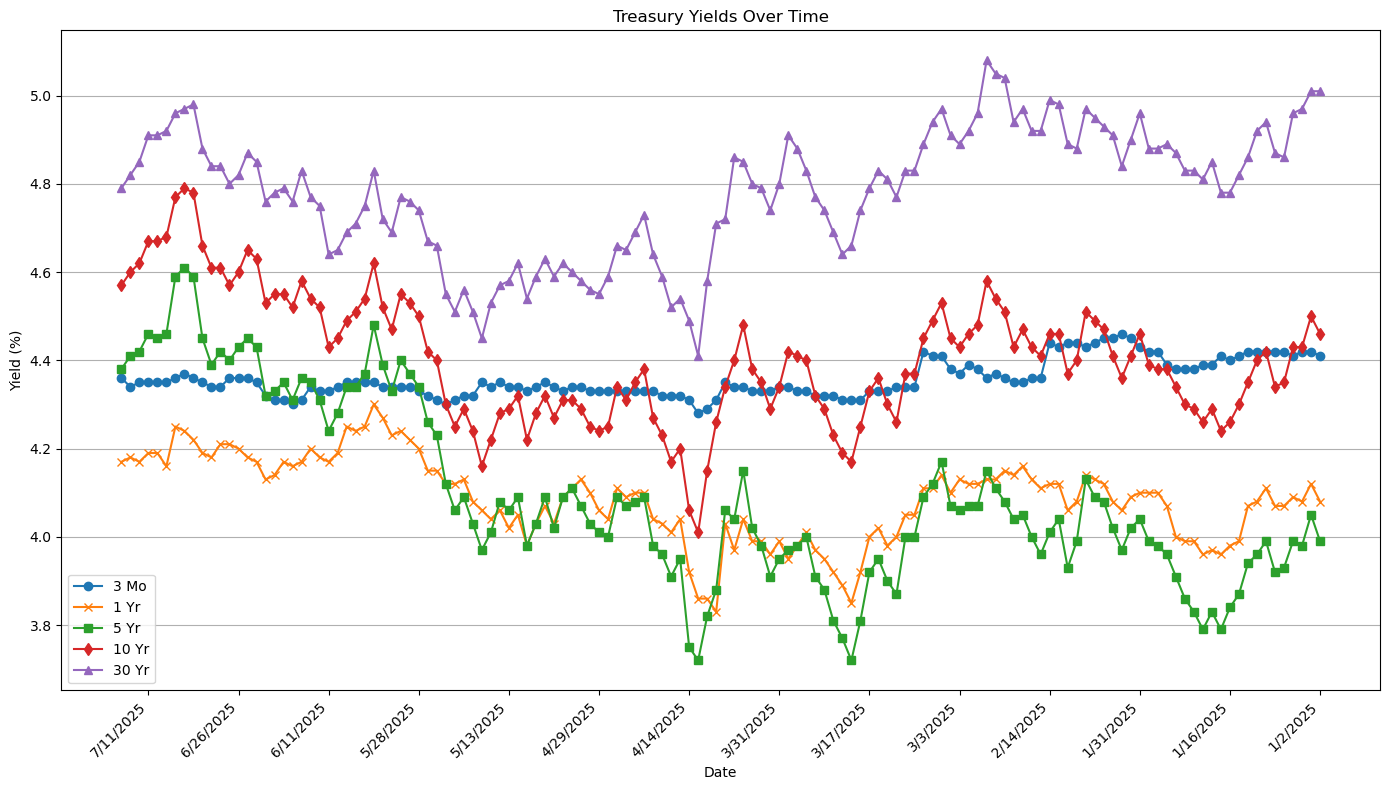

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.plot(rates_df['Date'], rates_df['3 Mo'], label='3 Mo', marker='o')
plt.plot(rates_df['Date'], rates_df['1 Yr'], label='1 Yr', marker='x')
plt.plot(rates_df['Date'], rates_df['5 Yr'], label='5 Yr', marker='s')
plt.plot(rates_df['Date'], rates_df['10 Yr'], label='10 Yr', marker='d')
plt.plot(rates_df['Date'], rates_df['30 Yr'], label='30 Yr', marker='^')

plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.title('Treasury Yields Over Time')

# Only show every 10th date label
n = 10  # adjust as needed
plt.xticks(ticks=rates_df.index[::n], labels=rates_df['Date'][::n], rotation=45, ha='right')

plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


## Vasicek Model

### Model calibration using MLE for 3 Mo data

In [53]:
rates_df_3mo = rates_df[['Date', '3 Mo']].copy()
rates_df_3mo['Rate'] = rates_df_3mo['3 Mo']/100

In [54]:
rates_df_3mo

,Date,3 Mo,Rate
133,1/2/2025,4.36,0.0436
132,1/3/2025,4.34,0.0434
131,1/6/2025,4.35,0.0435
130,1/7/2025,4.35,0.0435
129,1/8/2025,4.35,0.0435
...,...,...,...
4,7/10/2025,4.42,0.0442
3,7/11/2025,4.41,0.0441
2,7/14/2025,4.42,0.0442
1,7/15/2025,4.42,0.0442


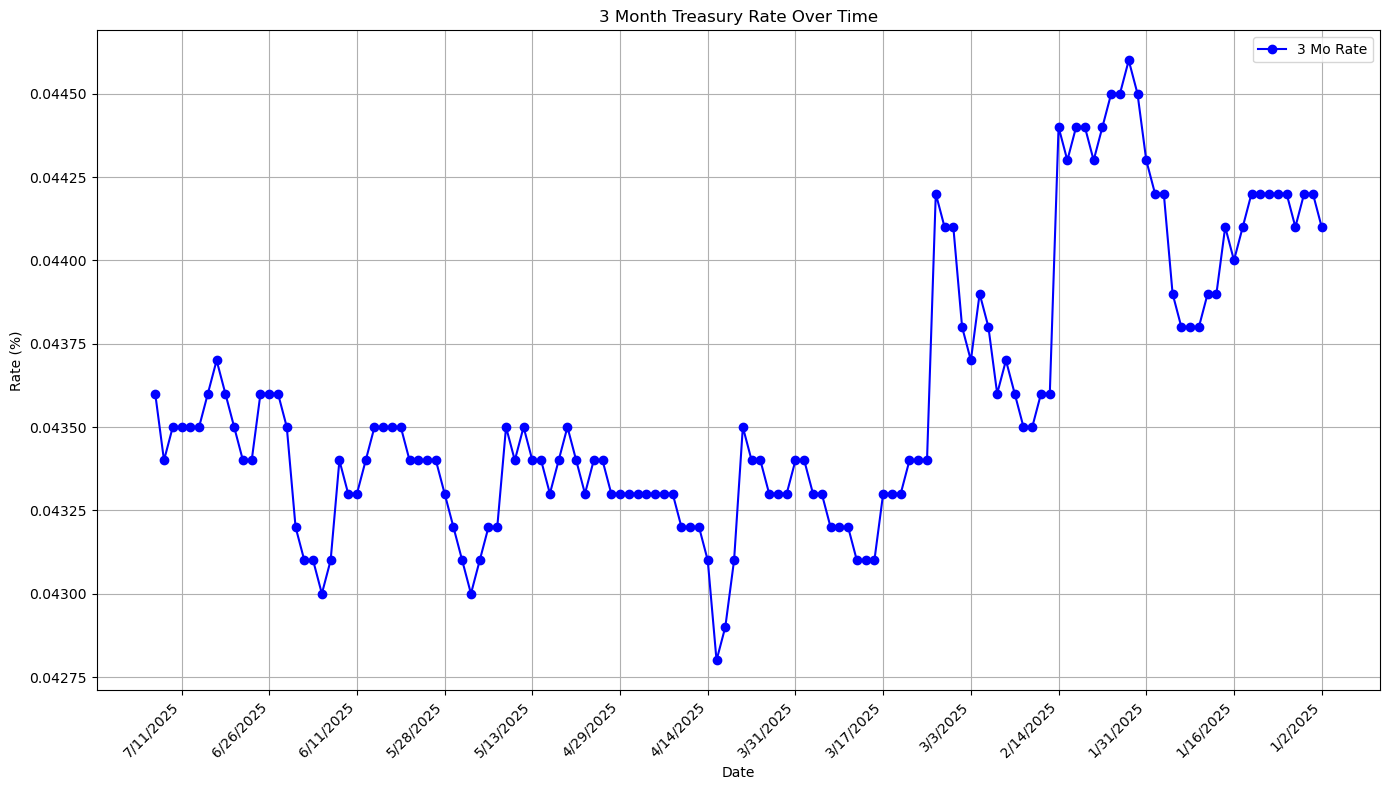

In [55]:
# plot the 3 month rates
plt.figure(figsize=(14, 8))
plt.plot(rates_df_3mo['Date'], rates_df_3mo['Rate'], marker='o', color='blue', label='3 Mo Rate')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.title('3 Month Treasury Rate Over Time')
# Only show every 10th date label
n = 10  # adjust as needed
plt.xticks(ticks=rates_df.index[::n], labels=rates_df['Date'][::n], rotation=45, ha='right')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [56]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm

# === INPUT: r_t should be a numpy array of daily short rates ===
# Example: r_t = np.array([0.004, 0.0041, 0.00405, ..., 0.005])

def vasicek_log_likelihood(params, r_t, dt):
    a, b, sigma = params
    r_t = np.array(r_t)
    r_tm1 = r_t[:-1]
    r_t = r_t[1:]

    # Mean and variance of transition distribution under Vasicek model
    mean = r_tm1 * np.exp(-a * dt) + b * (1 - np.exp(-a * dt))
    var = (sigma**2 / (2 * a)) * (1 - np.exp(-2 * a * dt))

    # Log-likelihood
    log_pdf = norm.logpdf(r_t, loc=mean, scale=np.sqrt(var))
    return -np.sum(log_pdf)  # negative log-likelihood for minimization

# === MAIN CALIBRATION FUNCTION ===
def calibrate_vasicek(rates, dt=1/252, r0=None):
    rates = np.array(rates)
    
    # Initial guesses: [a, b, sigma]
    a0, b0, sigma0 = 0.3, np.mean(rates), np.std(rates) / np.sqrt(dt)
    initial_params = [a0, b0, sigma0]
    
    bounds = [(0.001, None),    # a
              (0, 1),       # b
              (0.001, None)]    # sigma

    result = minimize(vasicek_log_likelihood, initial_params, args=(rates, dt), bounds=bounds)
    
    if not result.success:
        raise RuntimeError("Optimization failed:", result.message)

    a_hat, b_hat, sigma_hat = result.x
    r0 = r0 if r0 is not None else rates[::-1][0]
    
    return {
        'a': a_hat,
        'b': b_hat,
        'sigma': sigma_hat,
        'r0': r0,
        'n_days': len(rates),
        'dt': dt,
        'log_likelihood': -result.fun
    }


In [57]:
# Run Vasicek calibration on the decimal rates
calibrated_params = calibrate_vasicek(rates_df_3mo['Rate'].values)

# Pretty print the results
for k, v in calibrated_params.items():
    print(f"{k}: {v}")



a: 0.30071218025457125
b: 0.04673109542120338
sigma: 0.002355562325117784
r0: 0.0441
n_days: 134
dt: 0.003968253968253968
log_likelihood: 983.8470033919625


## Vasicek model simulation

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_vasicek(a, b, sigma, r0, n_days=252, n_paths=10000, dt=1/252, seed=2025):
    if seed is not None:
        np.random.seed(seed)
        
    r = np.zeros((n_paths, n_days + 1))
    r[:, 0] = r0

    for t in range(1, n_days + 1):
        Z = np.random.normal(0, 1, size=n_paths)
        r[:, t] = r[:, t - 1] + a * (b - r[:, t - 1]) * dt + sigma * np.sqrt(dt) * Z

    return r


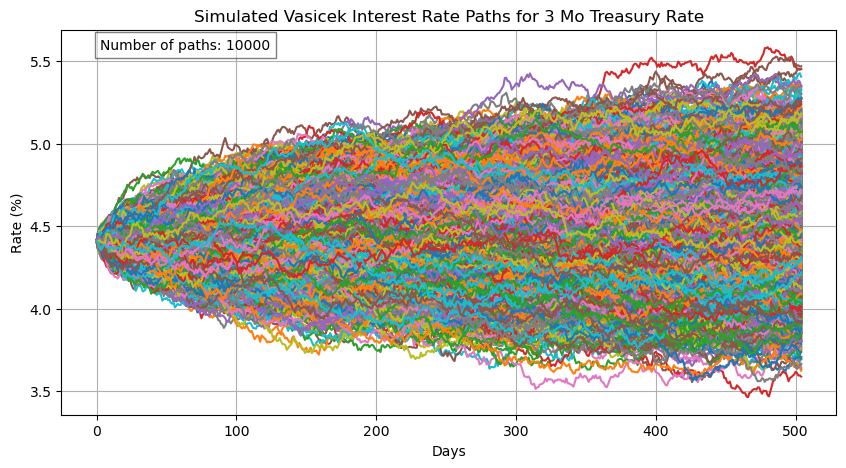

In [59]:
# Use your fitted parameters from calibration
a = calibrated_params['a']
b = calibrated_params['b']
sigma = calibrated_params['sigma']
r0 = calibrated_params['r0']
n_days = 504  # Simulate for 2 years (252 days/year * 2)

# Simulate 
r_vasicek = simulate_vasicek(a, b, sigma, r0, n_days=n_days, n_paths=10000, dt=1/252, seed=2025)

# Plotting
plt.figure(figsize=(10, 5))
for i in range(r_vasicek.shape[0]):
    plt.plot(r_vasicek[i] * 100)  # convert back to %
plt.title("Simulated Vasicek Interest Rate Paths for 3 Mo Treasury Rate")
plt.xlabel("Days")
plt.ylabel("Rate (%)")
# small box inside plot to show the number of simulations paths
plt.text(0.05, 0.95, f'Number of paths: {r_vasicek.shape[0]}', transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
plt.grid(True)
plt.savefig('simulated_vasicek_paths.png')
plt.show()

In [60]:
# arrange r_vasicek in a DataFrame with simulation 1, simulation 2, ..., simulation 100 as columns
r_vasicek_df = pd.DataFrame(r_vasicek.T, columns=[f'Simulation {i+1}' for i in range(r_vasicek.shape[0])])


In [61]:
r_vasicek_df

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 9991,Simulation 9992,Simulation 9993,Simulation 9994,Simulation 9995,Simulation 9996,Simulation 9997,Simulation 9998,Simulation 9999,Simulation 10000
0,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,...,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100
1,0.044089,0.044212,0.043890,0.044005,0.044088,0.044422,0.044310,0.044072,0.044216,0.044134,...,0.044148,0.044186,0.044017,0.043963,0.044351,0.043802,0.043953,0.044003,0.044070,0.044021
2,0.044289,0.043997,0.044061,0.044238,0.044017,0.044649,0.044345,0.044189,0.044276,0.043945,...,0.044331,0.044250,0.044130,0.043738,0.044334,0.043845,0.043668,0.043734,0.044152,0.043765
3,0.044216,0.044012,0.044206,0.044346,0.044136,0.044739,0.044443,0.044339,0.044279,0.044018,...,0.044221,0.044127,0.044058,0.043702,0.044246,0.043862,0.043614,0.043761,0.044038,0.043536
4,0.044162,0.044123,0.044281,0.044368,0.044057,0.044894,0.044474,0.044376,0.044364,0.044071,...,0.044322,0.043987,0.043920,0.043515,0.044076,0.043745,0.043858,0.043854,0.044026,0.043673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0.043971,0.044075,0.045616,0.048343,0.043170,0.047671,0.045358,0.044756,0.044846,0.044161,...,0.047181,0.045106,0.044472,0.044015,0.045423,0.043258,0.047170,0.048532,0.044003,0.042833
501,0.043658,0.043968,0.045687,0.048242,0.043086,0.047831,0.045283,0.044894,0.044765,0.044065,...,0.047060,0.044970,0.044264,0.043881,0.045320,0.043435,0.047102,0.048596,0.044025,0.042853
502,0.043656,0.043690,0.045522,0.048079,0.043034,0.047883,0.045208,0.045010,0.044799,0.044018,...,0.047277,0.044921,0.043881,0.043946,0.045461,0.043394,0.046902,0.048357,0.044137,0.042947
503,0.043592,0.043809,0.045337,0.048062,0.042964,0.047867,0.045298,0.045052,0.044923,0.044049,...,0.047421,0.044780,0.043793,0.043757,0.045149,0.043370,0.046911,0.048292,0.043913,0.042948


## CIR Model Simulation

In [62]:
def simulate_cir(a, b, sigma, r0, n_days=90, n_paths=10000, dt=1/252, seed=2025):
    if seed is not None:
        np.random.seed(seed)
    
    r = np.zeros((n_paths, n_days + 1))  
    r[:, 0] = r0  
    for t in range(1, n_days + 1):
        Z = np.random.normal(0, 1, size=n_paths)  
        
        
        sqrt_r = np.sqrt(np.maximum(r[:, t-1], 0))
        
        # CIR increment formula:
        # dr_t = a*(b - r_t)*dt + sigma * sqrt(r_t) * sqrt(dt) * Z
        dr = a * (b - r[:, t-1]) * dt + sigma * sqrt_r * np.sqrt(dt) * Z
        
        r[:, t] = r[:, t-1] + dr  
        
        
        r[:, t] = np.maximum(r[:, t], 0)
    
    return r


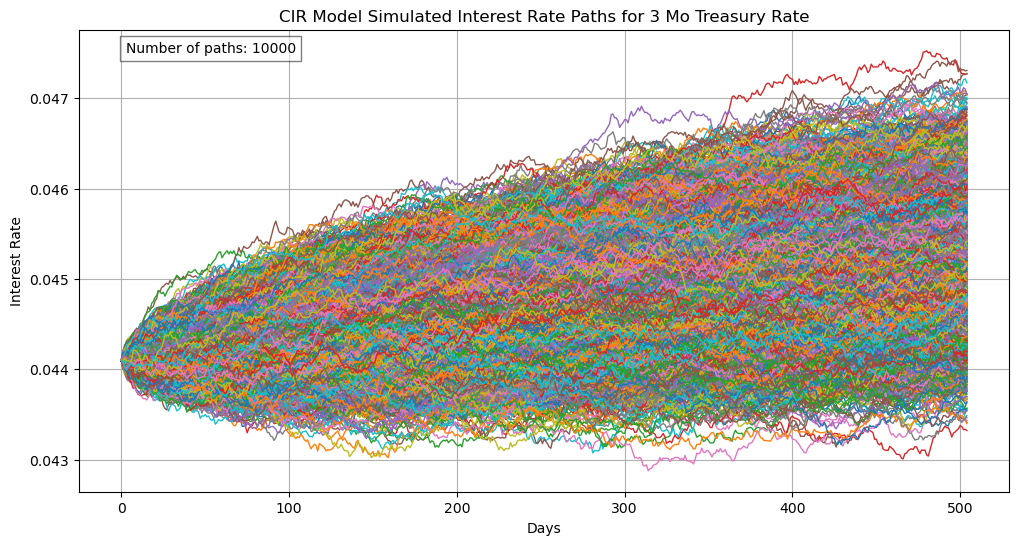

In [63]:
import matplotlib.pyplot as plt

# Simulate CIR paths
r_cir = simulate_cir(a, b, sigma, r0, n_days=504, n_paths=10000, dt=1/252, seed=2025)


plt.figure(figsize=(12,6))
for i in range(r_cir.shape[0]):
    plt.plot(r_cir[i], lw=1)
plt.title(f'CIR Model Simulated Interest Rate Paths for 3 Mo Treasury Rate')
plt.xlabel('Days')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.text(0.05, 0.95, f'Number of paths: {r_cir.shape[0]}', transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
plt.savefig('simulated_cir_paths.png')
plt.show()


In [64]:
# arrange r_cir in a DataFrame with simulation 1, simulation 2, ..., simulation 100 as columns
r_cir_df = pd.DataFrame(r_cir.T, columns=[f'Simulation {i+1}' for i in range(r_cir.shape[0])])

In [65]:
r_cir_df

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 9991,Simulation 9992,Simulation 9993,Simulation 9994,Simulation 9995,Simulation 9996,Simulation 9997,Simulation 9998,Simulation 9999,Simulation 10000
0,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,...,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100
1,0.044100,0.044126,0.044058,0.044082,0.044100,0.044170,0.044147,0.044097,0.044127,0.044110,...,0.044113,0.044121,0.044085,0.044074,0.044155,0.044040,0.044072,0.044082,0.044096,0.044086
2,0.044145,0.044083,0.044097,0.044134,0.044088,0.044220,0.044156,0.044124,0.044142,0.044072,...,0.044154,0.044137,0.044111,0.044029,0.044154,0.044051,0.044014,0.044028,0.044116,0.044035
3,0.044132,0.044089,0.044130,0.044159,0.044115,0.044242,0.044180,0.044158,0.044145,0.044090,...,0.044133,0.044113,0.044099,0.044024,0.044138,0.044057,0.044005,0.044036,0.044094,0.043989
4,0.044123,0.044115,0.044148,0.044166,0.044101,0.044277,0.044188,0.044168,0.044165,0.044104,...,0.044157,0.044086,0.044072,0.043987,0.044105,0.044035,0.044059,0.044058,0.044094,0.044020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0.045000,0.045026,0.045354,0.045932,0.044835,0.045789,0.045297,0.045172,0.045189,0.045044,...,0.045683,0.045242,0.045109,0.045013,0.045310,0.044853,0.045682,0.045971,0.045008,0.044767
501,0.044935,0.045005,0.045370,0.045912,0.044819,0.045824,0.045282,0.045203,0.045173,0.045024,...,0.045659,0.045214,0.045066,0.044986,0.045289,0.044892,0.045669,0.045986,0.045014,0.044772
502,0.044936,0.044948,0.045336,0.045878,0.044809,0.045837,0.045268,0.045229,0.045182,0.045016,...,0.045706,0.045205,0.044986,0.045002,0.045320,0.044884,0.045627,0.045936,0.045039,0.044793
503,0.044924,0.044974,0.045298,0.045876,0.044796,0.045835,0.045288,0.045239,0.045210,0.045024,...,0.045739,0.045177,0.044968,0.044963,0.045256,0.044881,0.045631,0.045923,0.044993,0.044795


# Pricing Derivatives

## Caps & Floors

In [66]:
initial_yield_curve

,Maturity,Yield %,Maturity (Years),Fitted Yield % OLS(NS),Fitted Yield % MLE (NS),Fitted Yield % OLS(NSS)
0,1 Mo,4.36,0.083,4.469,4.469,4.398
1,1.5 Mo,4.4,0.125,4.445,4.445,4.405
2,2 Mo,4.45,0.167,4.422,4.422,4.407
3,3 Mo,4.41,0.250,4.378,4.378,4.401
4,4 Mo,4.42,0.333,4.336,4.336,4.385
5,6 Mo,4.31,0.500,4.260,4.260,4.333
6,1 Yr,4.08,1.000,4.085,4.085,4.134
7,2 Yr,3.88,2.000,3.908,3.908,3.871
8,3 Yr,3.86,3.000,3.875,3.875,3.819
9,5 Yr,3.99,5.000,4.002,4.002,3.988


In [67]:
notional_value = 1000000  # Example notional value for the bond
cap_rate_strike = initial_yield_curve['Yield %'][3] / 100 #ATM strike rate for the cap
n_days = 504
freq = 63  # Quarterly payments (every 63 days)
payment_indices = list(range(0, n_days + 1, freq))
delta_t = 63 / 252  # Time between payments in years

In [68]:
payment_indices

[0, 63, 126, 189, 252, 315, 378, 441, 504]

In [69]:
# only keep the payment indices columns and rows
r_vasicek_df_freq = r_vasicek_df.iloc[payment_indices, :]
r_cir_df_freq = r_cir_df.iloc[payment_indices, :]

In [70]:
r_vasicek_df_freq

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 9991,Simulation 9992,Simulation 9993,Simulation 9994,Simulation 9995,Simulation 9996,Simulation 9997,Simulation 9998,Simulation 9999,Simulation 10000
0,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,...,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100,0.044100
63,0.045549,0.044520,0.042989,0.044525,0.043733,0.044418,0.046498,0.044108,0.043922,0.044874,...,0.044779,0.043476,0.044871,0.044048,0.044994,0.044341,0.043359,0.045434,0.045222,0.043833
126,0.047139,0.043748,0.041839,0.046377,0.042228,0.043968,0.045551,0.043706,0.044708,0.045244,...,0.044669,0.045863,0.044716,0.043311,0.044632,0.044447,0.045227,0.047833,0.046415,0.044981
189,0.046626,0.044081,0.043378,0.045501,0.041626,0.044176,0.043435,0.041322,0.044155,0.044758,...,0.045629,0.046326,0.045119,0.042783,0.046718,0.045764,0.046634,0.047607,0.046174,0.042919
252,0.045807,0.046007,0.043444,0.045437,0.042893,0.044484,0.044233,0.042001,0.042278,0.043602,...,0.046167,0.045799,0.045097,0.043659,0.046873,0.045819,0.046437,0.048103,0.046467,0.040365
315,0.045829,0.043151,0.045567,0.046265,0.044065,0.047296,0.043827,0.043594,0.045218,0.042598,...,0.047550,0.046312,0.045182,0.044442,0.045043,0.043000,0.046934,0.047360,0.046114,0.041691
378,0.046783,0.042980,0.045238,0.045969,0.045010,0.047464,0.044081,0.042998,0.044543,0.044634,...,0.047293,0.045658,0.044396,0.044044,0.043628,0.042660,0.046278,0.045719,0.044940,0.041654
441,0.045481,0.042032,0.043822,0.047405,0.044747,0.047707,0.044451,0.044404,0.045505,0.043892,...,0.047570,0.044662,0.044293,0.043940,0.045148,0.043042,0.046141,0.047986,0.044044,0.041542
504,0.043615,0.043791,0.045248,0.047974,0.042881,0.047651,0.045184,0.044593,0.045143,0.043956,...,0.047433,0.044828,0.043789,0.043847,0.045454,0.043306,0.047132,0.048377,0.043868,0.042968


In [71]:
# Caps pricing function
n_payments = r_vasicek_df_freq.shape[0]
n_sims = r_vasicek_df_freq.shape[1]
risk_free_rate = 0.04

In [72]:
long_cap = notional_value * np.maximum(r_vasicek_df_freq.values - cap_rate_strike, 0) * delta_t
short_cap = notional_value * np.maximum(r_vasicek_df.values - cap_rate_strike, 0) * delta_t
long_floor = notional_value * np.maximum(cap_rate_strike - r_vasicek_df_freq.values, 0) * delta_t
short_floor = notional_value * np.maximum(cap_rate_strike - r_vasicek_df_freq.values, 0) * delta_t

In [73]:
def price_cap(notional_value,model_simulation_data, risk_free_rate, delta_t, cap_rate_strike):
    long_cap = notional_value * np.maximum(model_simulation_data.values - cap_rate_strike, 0) * delta_t
    short_cap = notional_value * -np.maximum(model_simulation_data.values - cap_rate_strike, 0) * delta_t
    long_cap = pd.DataFrame(long_cap, columns=model_simulation_data.columns)
    short_cap = pd.DataFrame(short_cap, columns=model_simulation_data.columns)
    long_cap_price = np.sum(long_cap, axis=0).mean() * np.exp(-risk_free_rate * delta_t * (n_payments-1))
    short_cap_price = np.sum(short_cap, axis=0).mean() * np.exp(-risk_free_rate * delta_t * (n_payments-1))
    return long_cap_price, short_cap_price
    


In [74]:
long_cap_price_vasi, short_cap_price_vasi = price_cap(notional_value, r_vasicek_df_freq, risk_free_rate, delta_t, cap_rate_strike=0.049)
long_cap_price_cir, short_cap_price_cir = price_cap(notional_value, r_cir_df_freq, risk_free_rate, delta_t, cap_rate_strike=0.049)
print(f"Long Cap Price (Vasicek): {long_cap_price_vasi:.2f}")
print(f"Short Cap Price (Vasicek): {short_cap_price_vasi:.2f}")
print(f"Long Cap Price (CIR): {long_cap_price_cir:.2f}")
print(f"Short Cap Price (CIR): {short_cap_price_cir:.2f}")

Long Cap Price (Vasicek): 56.25
Short Cap Price (Vasicek): -56.25
Long Cap Price (CIR): 0.00
Short Cap Price (CIR): 0.00


In [75]:
def price_floor(notional_value, model_simulation_data, risk_free_rate, delta_t, cap_rate_strike):
    long_floor = notional_value * np.maximum(cap_rate_strike - model_simulation_data.values, 0) * delta_t
    short_floor = notional_value * -np.maximum(cap_rate_strike - model_simulation_data.values, 0) * delta_t
    long_floor = pd.DataFrame(long_floor, columns=model_simulation_data.columns)
    short_floor = pd.DataFrame(short_floor, columns=model_simulation_data.columns)
    long_floor_price = np.sum(long_floor, axis=0).mean() * np.exp(-risk_free_rate * delta_t * (n_payments-1))
    short_floor_price = np.sum(short_floor, axis=0).mean() * np.exp(-risk_free_rate * delta_t * (n_payments-1))
    return long_floor_price, short_floor_price

In [76]:
long_floor_price_vasi, short_floor_price_vasi = price_floor(notional_value, r_vasicek_df_freq, risk_free_rate, delta_t, cap_rate_strike=0.049)
long_floor_price_cir, short_floor_price_cir = price_floor(notional_value, r_cir_df_freq, risk_free_rate, delta_t, cap_rate_strike=0.049)
print(f"Long Floor Price (Vasicek): {long_floor_price_vasi:.2f}")
print(f"Short Floor Price (Vasicek): {short_floor_price_vasi:.2f}")
print(f"Long Floor Price (CIR): {long_floor_price_cir:.2f}")
print(f"Short Floor Price (CIR): {short_floor_price_cir:.2f}")

Long Floor Price (Vasicek): 8911.94
Short Floor Price (Vasicek): -8911.94
Long Floor Price (CIR): 8838.58
Short Floor Price (CIR): -8838.58


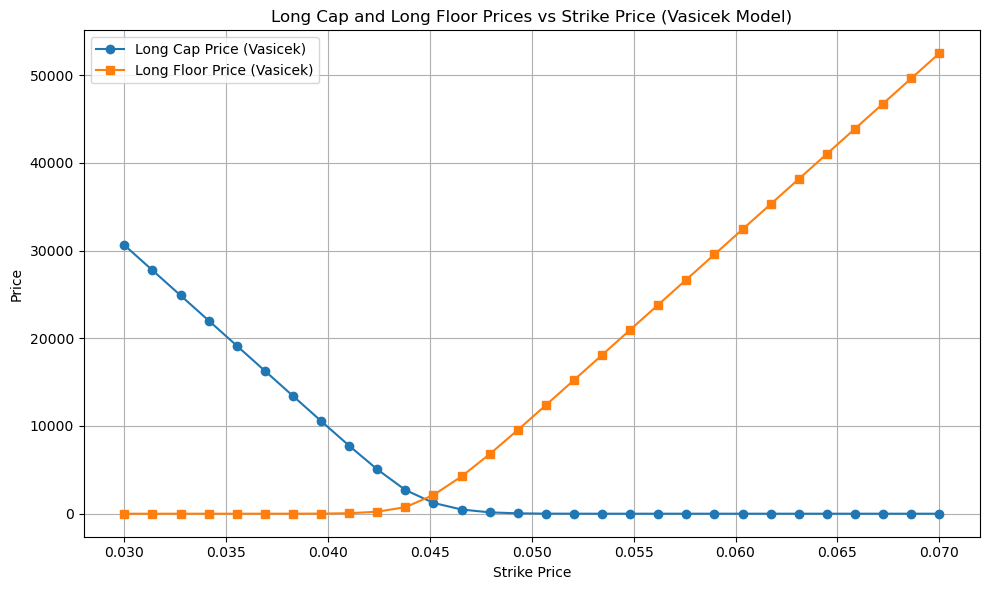

In [79]:
# Plot long cap and long floor price for different strike prices

strike_prices = np.linspace(0.03, 0.07, 30)  # Range of strike prices (3% to 7%)
long_cap_prices_vasi = []
long_floor_prices_vasi = []

for strike in strike_prices:
    long_cap_price, _ = price_cap(notional_value, r_vasicek_df_freq, risk_free_rate, delta_t, cap_rate_strike=strike)
    long_floor_price, _ = price_floor(notional_value, r_vasicek_df_freq, risk_free_rate, delta_t, cap_rate_strike=strike)
    long_cap_prices_vasi.append(long_cap_price)
    long_floor_prices_vasi.append(long_floor_price)

plt.figure(figsize=(10, 6))
plt.plot(strike_prices, long_cap_prices_vasi, label='Long Cap Price (Vasicek)', marker='o')
plt.plot(strike_prices, long_floor_prices_vasi, label='Long Floor Price (Vasicek)', marker='s')
plt.xlabel('Strike Price')
plt.ylabel('Price')
plt.title('Long Cap and Long Floor Prices vs Strike Price (Vasicek Model)')
plt.legend()
plt.grid(True)
plt.tight_layout()

## Bonds with embedded options

### Callable bonds

In [ ]:
Face_value = 100
coupon_rate = 0.05
Maturity = 2 # 2 years
Payment_frequency = 1 # year
call_price = 102
call_schedule = 